In [7]:
import pickle
import numpy as np
import networkx as nx
from multiprocessing import Pool
from collections import Counter

import matplotlib as mplt
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from altProts_in_communities.utils import *

In [8]:
G_o = pickle.load(open('G_o.pkl', 'rb'))

In [10]:
color_palette = {
    'ref_prey': '#2582c6',
    'ref_bait': '#093e63',
    'alt': '#e76f51',
    'light': '#D81159',
    'yellow':'#9b7021',
    'dark': '#093e63'
    }

def get_graph_vis(G,
                  title,
                  file_name=None,
                  file_path=None,
                  layout=None,
                  layout_params={'k':0.15, 'iterations':20},
                  figsize=None,
                  pos=None,
                  start_pos=None,
                  fixed_nodes=None,
                  return_pos=False,
                  edge_alpha=1.0,
                  edge_width=1.0,
                  node_size=20,
                  alt_node_size=15,
                  graph_type='alt_bait_prey',
                  min_source_margin=0,
                  draw_labels=False,
                  margin=0.1,
                  include_ledgend=False,
                  GO=None,
                 ):
    if figsize is None:
        figsize = (10,4)
    elif figsize == 'auto' and GO is not None:
        leg_width_char = get_max_char_count(GO)
        figsize = (4+0.18*leg_width_char, 4)
    fig, ax = plt.subplots(figsize=figsize)
    #options = {'node_color': 'black', 'node_size': 50, 'width': 1}
    if pos is None:
        if layout is not None:
            pos = layout(G)
        if start_pos is not None and fixed_nodes is not None:
            pos = nx.spring_layout(G, pos=start_pos, fixed=fixed_nodes, k=layout_params['k'], iterations=layout_params['iterations'])
        else:
            pos = nx.spring_layout(G, k=layout_params['k'], iterations=layout_params['iterations'])
        
    nx.draw_networkx_edges(G, pos, edge_color='black', width=edge_width, alpha=edge_alpha, ax=ax)
    
    if GO is not None:
        gene_go_count = get_gene_go_count(GO)
        r=0.03
        cycle_fact = lambda : itt.cycle([(r*np.cos(x), r*np.sin(x)) for x in range(0, 360, 45)])
        gene_cir_pos = {gene:cycle_fact() for gene in gene_go_count}
        legend_elements = []
        gopos = pos.copy()
        for GO_type, GO_terms in GO.items():
            for GO_term in GO_terms:
                study_items = GO_term['study_items'].split('|')
                GO_color = next(GO_colors)
                legend_elements.append(Line2D([0], [0], marker='o', label='{}\n{}'.format(GO_term['go_name'], GO_term['study_items']), color=GO_color))
                for gene, count in gene_go_count.items():
                    next(gene_cir_pos[gene])
                    next(gene_cir_pos[gene])
                    gopos[gene] = pos[gene]+next(gene_cir_pos[gene])
                    gene_go_count[gene] -= 1
                nx.draw_networkx_nodes(G, gopos,
                                   nodelist=study_items,
                                   node_color=GO_color,
                                   node_size=node_size+(node_size*2.0),
                                   ax=ax,
                                    alpha=0.6
                                      )
        
    nx.draw_networkx_nodes(G, pos,
                       nodelist=[x for x,y in G.nodes(data=True) if y['tt_type']=='ref' and y['node_type']=='bait'],
                       node_color=color_palette['ref_bait'],
                       node_size=node_size,
                       ax=ax)

    nx.draw_networkx_nodes(G, pos,
                       nodelist=[x for x,y in G.nodes(data=True) if y['tt_type']=='ref' and y['node_type']=='prey'],
                       node_color=color_palette['ref_prey'],
                       node_size=node_size,
                       ax=ax)

    nx.draw_networkx_nodes(G, pos,
                       nodelist=[x for x,y in G.nodes(data=True) if y['tt_type']=='alt'],
                       node_color=color_palette['light'],
                       node_size=alt_node_size,
                       ax=ax)

    if draw_labels:
        nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)
    
    ax.axis('off')
    
    plt.margins(margin)
    if file_name is not None and file_path is not None:
        plt.savefig(file_path+file_name, dpi=600, transparent=True)
    plt.show()
    
    if GO is not None and include_ledgend:
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.legend(handles=legend_elements)
        ax.axis('off')
        ax.set_title(title)
        plt.savefig(file_path+file_name.replace('.', '_legend.'), dpi=600, transparent=True)
        plt.show()
    if return_pos:
        return file_name, file_name.replace('.', '_legend.'), pos
    return file_name, file_name.replace('.', '_legend.')

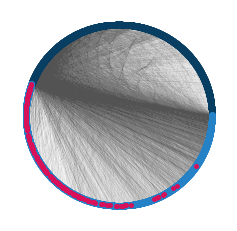

('full_net.png', 'full_net_legend.png')

In [16]:
deg_cen = nx.degree_centrality(G_o)

node_types = {}
for n in list(G_o.nodes())+list(G_o.nodes()):
    node_types[n] = {}
    if n in bait_batch_dict:
        node_types[n]['node_type'] = 'bait'
    else:
        node_types[n]['node_type'] = 'prey'
nx.set_node_attributes(G_o, node_types)

deg = G_o.degree()

pos = nx.circular_layout(sorted(G_o.nodes(), key=lambda x: [node_types[x]['node_type'], deg_cen[x]]))

get_graph_vis(G_o, '',
              layout=nx.circular_layout,
              figsize=(4,4),
              pos=pos,
              edge_alpha=0.01,
              node_size=30,
              file_path='bioplex_figures/',
              file_name='full_net.png',
             )

In [12]:
sorted([(node, cen) for node, cen in deg_cen.items() if 'IP_' in node], key=lambda x: -x[1])[:10]

[('TUBB8P11|IP_673226', 0.0006454944487477407),
 ('RNF215|IP_293201', 0.0005163955589981926),
 ('SLC38A10|IP_711679', 0.0005163955589981926),
 ('SEPT7P8|IP_686636', 0.00038729666924864443),
 ('BEND4|IP_117582', 0.00038729666924864443),
 ('ENO1P1|IP_079312', 0.00038729666924864443),
 ('AC008758.4|IP_691643', 0.00038729666924864443),
 ('AC092329.4|IP_688853', 0.00038729666924864443),
 ('UBBP4|IP_710744', 0.00038729666924864443),
 ('HSPA8P5|IP_763499', 0.0002581977794990963)]

In [17]:
node_size = 300
margin = 0.1
node = 'UBBP4|IP_710744'
G_neig = get_2degneigb(G_o, node)
file_name, legend = get_graph_vis(
                G_neig,
                '{}'.format(node),figsize=(5,5),
                node_size=node_size,
                alt_node_size=node_size,
                layout_params={'k':0.35, 'iterations':50},
                file_name='second_neighb_{}_withalt.svg'.format(node),
                file_path='bioplex_figures/subnets/2nd_deg_neighb/',
                draw_labels=False,
                margin=margin,
        )

NameError: name 'get_2degneigb' is not defined

In [7]:
def batch_apsp(batch_nodes):
    apsp = {}
    for n in batch_nodes:
        ss_sp = Counter(nx.single_source_shortest_path_length(G, n).values())
        for c in ss_sp:
            if c not in apsp:
                apsp[c] = 0
            apsp[c] += ss_sp[c]
                
    return apsp

# reanalysis APSP
G = G_o.copy()
n_nodes = 1000
nodes_splited = [list(G.nodes())[i:i+n_nodes] for i in range(0, len(G.nodes()), n_nodes)]
pool = Pool(8)
r = pool.map_async(batch_apsp, nodes_splited)
results = r.get()
pool.close()
pool.join()

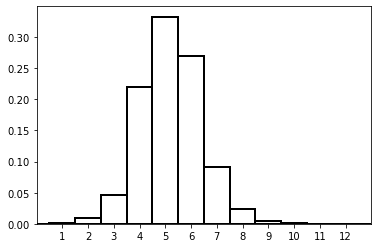

In [8]:
# aggregate results from parallel runs
apsp = {}
for r in results:
    for sp_len in r:
        if sp_len in apsp:
            apsp[sp_len] += r[sp_len]
        else:
            apsp[sp_len] = r[sp_len]

n_pairs = sum(apsp.values())
whole_sp, whole_dens = zip(*[(k, v/n_pairs) for k,v in apsp.items()])
average_sp = sum(np.array(whole_sp) * np.array(list(apsp.values()))) / n_pairs
fig, ax = plt.subplots()
width = 1.0
ax.bar(whole_sp,         whole_dens, width, edgecolor='k', color='w', linewidth=2 , alpha=1.0, label='whole network')
#ax.bar(np.array(ref_sp), ref_dens,   width, color='#006ba6', alpha=0.8, label='refProts')
#ax.bar(np.array(alt_sp), alt_dens,   width, color='#d81159', alpha=0.6, label='altProts')
plt.xticks(range(1, 13))
plt.xlim(0, 13)
#plt.legend()
plt.savefig('bioplex_figures/apsp_bar.svg')
plt.show()

In [9]:
def power_law_discrete_MLE(binned_data, x_min):
    binned_data = [x for x in binned_data if x>x_min]
    n = len(binned_data)
    a = 1+n/(sum(np.log(x/x_min-0.5) for x in binned_data))
    return a

def power_fit(x_min=12):
    G = G_o.copy()
    all_degrees = [x for x in dict(G.degree()).values() if x>0]
    h = plt.hist(all_degrees, histtype='step', bins=140, density=True)

    data_x = h[1][:-1][h[0]>0]
    data_y = h[0][h[0]>0]

    x = np.linspace(0.1, 187, 10)
    a = power_law_discrete_MLE(data_x, x_min)
    print(a)
    p_x = x**(-a)


    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(data_x, data_y, c='#7a3350', s=4)
    ax.plot(x, p_x, 'k', linestyle='dashed')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_yticks([0.005, 0.01, .05, .01, .5, 1])
    ax.set_xticks([5,10,50,100])
    ax.get_xaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    ax.set_xlim(0.8, 170)
    ax.set_ylim(0, 1)
    plt.savefig('bioplex_figures/degree_dist.svg')
    plt.show()

1.8711468501343704


/home/sleblanc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


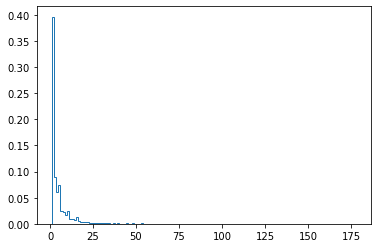

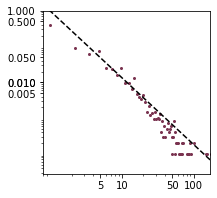

In [10]:
power_fit()

In [11]:
eig_cen = nx.eigenvector_centrality_numpy(G_o)
alt_eig_cen = [x for x in eig_cen.items() if is_alt(x[0])]
sorted_eig_cen = sorted([(k, v) for k,v in eig_cen.items()], key=lambda x: x[1])

alt_cen = [1 if is_alt(x[0]) else 0 for x in sorted_eig_cen]

cm = LinearSegmentedColormap.from_list('whatevs', ['#fff', '#501930'], N=100)

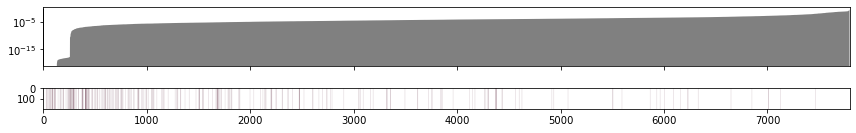

In [12]:
fig, axs = plt.subplots(2, figsize=(12,2), sharex=True)
x = range(len(eig_cen))
y = sorted(eig_cen.values())
axs[0].plot(y, y, c='k')
axs[0].fill_between(x, y, facecolor='grey')
axs[0].set_yscale('log')
axs[0].set_yticks([1e-15, 1e-5])
axs[1].imshow([alt_cen,]*200, cmap=cm)
#plt.xticks([0, 4000, 8000])

plt.tight_layout()
plt.savefig('bioplex_figures/eig_cen.svg', dpi=600)